# The Notorious Algoritm by Mark תשוקה


Additionals:

*   Deal with ordinal variables - currently something is not working

In [1]:
!pip install networkx matplotlib

In [3]:
import numpy as np
import pandas as pd
import math
import random
from scipy.stats import chi2
from scipy.optimize import fsolve
import networkx as nx
import matplotlib.pyplot as plt

In [46]:
class IFN:
    '''
    IFN model implementation.
    This implementation can only handle discrete target column.
    The ordinal columns binarization is a simplifed version, deciding on the optimal bins per column
    before starting to build the network.
    '''
    class Node:
        '''
        Node class for the IFN model.
        '''
        def __init__(self, data, level_attr = 'root', level_attr_val = None, is_terminal=False, color = 'blue'):
            '''
            Initialize the node.
            Args:
                data: pandas DataFrame, the subset of the data at node Z.
                level_attr: The name of the feature on that nodes level.
                level_attr_val: The value of that node in level_attr.
                is_terminal: bool, whether the node is a terminal node.
                color: str, the color of the node.
            '''
            self.data = data
            self.level_attr = level_attr
            self.level_attr_val = level_attr_val
            self.split_attr = None
            self.children = []
            self.is_terminal = is_terminal
            self.color = color


    def __init__(self, train_data, target, P_VALUE_THRESH = 0.1, max_depth = None, weights_type = 'probability'):
        self.train_data = train_data
        self.target = target
        self.P_VALUE_THRESH = P_VALUE_THRESH
        self.input_vars = {col: 0 for col in train_data.columns if col != target}  # Input vars with 1 for 'used'
        self.N = len(train_data)
        self.bin_suggestions = self._init_create_bin_suggestions()   # A simplified version of thresh optimization
        print(self.bin_suggestions)
        self.root = IFN.Node(train_data, level_attr = 'root', color = 'purple')
        self.target_nodes = self._init_target_nodes()
        self.nodes = [self.root] + self.target_nodes
        self.levels = []
        self.edges = []   # A tuple like (pointer, poitee, weight), all non terminal nodes get weight == None
        self.max_depth = max_depth
        self.weights_type = weights_type  # 'mutual' or 'probability'


    def _init_target_nodes(self):
        '''
        Initialize the target nodes based on the unique values in the target variable.
        '''
        target_values = self.train_data[self.target].unique()
        target_nodes = [IFN.Node(self.train_data[self.train_data[self.target] == val], level_attr = 'target', level_attr_val = val, is_terminal=True, color = 'red') for val in target_values]
        for target_node in target_nodes:
            print(f'[Initiate Model Status]: Target Class Initiated: "{target_node.level_attr_val}", No. Records = {len(target_node.data)}')
        return target_nodes


    def _init_create_bin_suggestions(self):
        '''
        Return value is a dictionary of suggestions for binning per column, if column
        type is 'ordinal'.
        {column_name: [tresh_val_1, tresh_val_2,...]}
        '''
        def find_best_threshold(data, col):
            """
            Find the best threshold for a given column in the data.

            Args:
                data: pandas DataFrame, the dataset.
                col: string, the column name.

            Returns:
                The best threshold value and its significance score.
            """
            unique_vals = sorted(data[col].unique())
            best_threshold = None
            max_significance = 0

            for T in unique_vals:
                bin_column = data[col].apply(lambda x: 0 if x < T else 1)
                temp_data = data.copy()
                temp_data[col] = bin_column
                significance = self._significance_test(temp_data, col)
                if significance > max_significance:
                    max_significance = significance
                    best_threshold = T

            return best_threshold, max_significance

        def recursive_find_splits(data, col, thresholds=None):
            """
            Recursively find the best splits for a given column in the data.

            Args:
                data: pandas DataFrame, the dataset.
                col: string, the column name.
                thresholds: list, the list of thresholds (default is None).

            Returns:
                List of thresholds.
            """
            if thresholds is None:
                thresholds = []

            best_threshold, max_significance = find_best_threshold(data, col)

            if best_threshold is not None and max_significance > 0:
                thresholds.append(best_threshold)
                print(f"Found significant split at {best_threshold} with significance {max_significance}")

                # Split the data into two subsets
                left_data = data[data[col] < best_threshold]
                right_data = data[data[col] >= best_threshold]

                # Recursively find splits in each subset
                if not left_data.empty:
                    recursive_find_splits(left_data, col, thresholds)
                if not right_data.empty:
                    recursive_find_splits(right_data, col, thresholds)

            return sorted(thresholds)
        numerical_columns = [col for col in self.train_data.columns if col != self.target and pd.api.types.is_numeric_dtype(self.train_data[col])]
        if not numerical_columns:
            return {}
        print(f'[Training Status]: Looking for optimal thresh points in numerical columns')
        bin_suggestions = {}

        for col in numerical_columns:
            print(f"Processing column: {col}")
            thresholds = recursive_find_splits(self.train_data, col)
            if thresholds:
                bin_suggestions[col] = thresholds

        # Create thresh per level if attr is ordinal
        for attr in bin_suggestions:
          bin_suggestions[attr] = [-float('inf')] + bin_suggestions[attr] + [float('inf')]
          bin_column = pd.cut(self.train_data[attr], bins=bin_suggestions[attr], labels=False)
          self.train_data[attr] = bin_column
        return bin_suggestions


    def _mutual_information(self, data, input):
        '''
        Mutual information calculation for the IFN model, calculated as a sum of all
        conditional mutual informations per xi in X (input variables) compared to Y (target variable).
        It's the sum of the Conditional Mutual Information for a node (xi) in the input variable, based on node.data.
        The final MI score for an attr is the sum of it's .

        Args:
            data: the subset of the data at node Z.
            self.N: int, total number of rows in the full data set.
            input: string, the input variable (column name) for which mutual information is calculated.
            self.target: string, the target variable (column name).

        Returns:
            float: The mutual information value.
        '''
        Z = len(data)
        mi = 0
        for yi in data[self.target].unique():
            for xi in data[input].unique():
                P_Yj_Xi = len(data[(data[input] == xi) & (data[self.target] == yi)]) / self.N
                P_Yj_Xi_Z = len(data[(data[input] == xi) & (data[self.target] == yi)]) / Z
                P_Xi_Z = len(data[data[input] == xi]) / Z
                P_Yj_Z = len(data[data[self.target] == yi]) / Z

                if P_Yj_Xi == 0 or P_Xi_Z == 0 or P_Yj_Z == 0:
                    mci = 0
                else:
                    mci = P_Yj_Xi * np.log2(P_Yj_Xi_Z / (P_Xi_Z * P_Yj_Z))

                mi += mci
        return mi


    def _significance_test(self, data, attr):
        '''
        H0 = Mutual Information == 0
        H1 = Mutual Information != 0

        Test using chi2 test.
        '''
        mi = self._mutual_information(data, attr)
        statistic = 2 * math.log(2) * self.N * mi

        k = len(data[attr].unique())
        m = len(data[self.target].unique())
        dof = (k - 1) * (m - 1)

        critical_value = chi2.ppf(1 - self.P_VALUE_THRESH, dof)
        return mi if statistic >= critical_value else 0


    def _best_split(self, level):
        '''
        Return the next attr to split by.
        Attr are picked by the level, meaning, each level can only have one attr.
        The best attr is the one with the highest mutual information, across all nodes created by an input variable.
        Each level holds all of the train_data, and decision is made by the best variable in that level.
        When an attr is chosen, all nodes unsplitable by that attr are marked as terminal.
        Function also handles edges to target nodes in cases of terminal nodes.

        Args:
            level: The nodes from the previous split. A list of nodes.

        Returns:
            string: the name of the best variable to split on.
        '''
        available_attributes = [col for col in self.input_vars if self.input_vars[col] == 0]
        max_mi = 0
        best_attr = None
        terminal_nodes = []
        for attr in available_attributes:
            mi_0_nodes = []   # Nodes that will turn terminal if this attr is chosen
            mi = 0
            if attr in self.bin_suggestions:
              level_bins = self.bin_suggestions[attr]
            for node in level:
              # Calculate MI
              node_mi = self._significance_test(node.data, attr)
              mi_0_nodes.append(node) if node_mi == 0 else None
              mi += node_mi
            if mi > max_mi:
                max_mi = mi
                best_attr = attr
                terminal_nodes = mi_0_nodes

        # Mark the best attribute as used
        if not best_attr or self.max_depth == 0:
            terminal_nodes = level
        else:
            self.input_vars[best_attr] = 1  # Mark the best attribute as used
            if isinstance(self.max_depth, int):
              self.max_depth -= 1

        # Connect terminal nodes to target nodes
        for node in terminal_nodes:
            node.is_terminal = True
            for target_node in self.target_nodes:
              node.children.append(target_node)
              w = self._edge_weight(node, target_node)
              self.edges.append((node, target_node, w))

        return best_attr


    def _edge_weight(self, node, target_node):
      '''
      Calculates the weight of an edge from a terminal node to a target node.
      '''
      node_n_of_records = len(node.data)
      mutual_n_of_records = len(node.data[node.data[self.target] == target_node.level_attr_val])
      target_n_of_records = len(target_node.data)


      P_Y = target_n_of_records / self.N
      P_Y_given_node = mutual_n_of_records / node_n_of_records
      P_mutual = mutual_n_of_records / self.N
      return {'weight': P_mutual * np.log2(P_Y_given_node/P_Y),
              'probability': P_Y_given_node}


    def _build_network(self, level, level_name='root'):
        '''
        Build the network recursively.
        If a node is terminal, node's children are the target nodes,
        else, children are the possible values of best_attr.

        Args:
            level: The nodes from the previous split. A list of nodes.
            level_name: The name of the level, the previous 'best attr'.
        '''
        if not level:
            return

        self.levels.append(level)
        # Choose the best attr for all level nodes
        best_attr = self._best_split(level)
        print(f'[Train Status]: Current Level: {level_name}, Best Split: {best_attr}')
        if best_attr is None:
            print(f'[Train Status]: No attribute was chosen, define level nodes as terminal and exit function')
            self.levels.append(self.target_nodes)
            return

        next_level = []
        level_name = best_attr
        level_data = pd.concat([node.data for node in level if not node.is_terminal])
        for value in level_data[best_attr].unique():
          subset = level_data[level_data[best_attr] == value]
          child_node = IFN.Node(subset, level_attr=best_attr, level_attr_val=value)
          self.nodes.append(child_node)
          next_level.append(child_node)
          for node in level:
            if not node.is_terminal:
              node.split_attr = best_attr
              self.edges.append((node, child_node, None))
              node.children.append(child_node)
        self._build_network(next_level, level_name)


    def fit(self):
        self._build_network([self.root])
        # Clean unused numerical column names
        self.bin_suggestions = {column: self.bin_suggestions[column] for column in self.bin_suggestions if self.input_vars[column] == 1}


    def plot_network(self):
        G = nx.DiGraph()
        colors = []
        pos = {}
        labels = {}

        # Add nodes to the graph
        for level_index, level in enumerate(self.levels):
            for node_index, node in enumerate(level):
                node_id = id(node)
                G.add_node(node_id)
                colors.append(node.color)
                # Assign positions based on level and order within the level
                pos[node_id] = (node_index, -level_index)
                # Add label if the node is a target node
                if node.color == 'red':
                    labels[node_id] = node.level_attr_val

        # Add edges to the graph, only include weights that are not None
        edge_labels = {}
        for (parent, child, weight) in self.edges:
            parent_id = id(parent)
            child_id = id(child)
            # Ensure weight is a valid number and not None
            if weight is not None:
                # Decide which edge label to plot
                if self.weights_type == 'probability':
                    rounded_weight = round(weight['probability'], 2)
                else:
                    rounded_weight = round(weight['weight'], 2)
                G.add_edge(parent_id, child_id, weight=rounded_weight)
                edge_labels[(parent_id, child_id)] = rounded_weight
            else:
                G.add_edge(parent_id, child_id)

        # Create a wider figure
        plt.figure(figsize=(20, 10))  # Adjust the width and height as needed
        # Draw the graph
        nx.draw(G, pos, with_labels=False, node_color=colors, node_size=300)
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='black')

        # Draw edge labels with smaller font size and rounded values
        edge_label_options = {
            "font_size": 12,
            "rotate": False,
        }
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, **edge_label_options)

        plt.show()


    def calculate_min_error_probability(self):
        """
        Calculate the minimum prediction error P_e based on Fano's Inequality using the complete feature set.

        Returns:
            float, the minimum prediction error P_e.
        """
        # Calculate the entropy H(A) of the target attribute
        prob = self.train_data[self.target].value_counts(normalize=True)
        entropy = -np.sum(prob * np.log2(prob))

        # Calculate the mutual information MI(A;I) as the sum of weights across all edges in the IFN
        mi = sum(weight['weight'] for _, _, weight in self.edges if weight is not None and isinstance(weight['weight'], (float, int)) and not np.isnan(weight['weight']))

        # Calculate the conditional entropy H(A|I)
        h_conditional = entropy - mi

        # Determine the number of classes M in the target attribute
        num_classes = self.train_data[self.target].nunique()

        # Define the Fano's inequality function to solve for P_e
        def fano_inequality(P_e):
            return h_conditional - (-P_e * np.log2(P_e) - (1 - P_e) * np.log2(1 - P_e) + P_e * np.log2(num_classes - 1))

        # Try multiple initial guesses for P_e
        initial_guesses = [0.1, 0.5, 0.9]
        for guess in initial_guesses:
            try:
                min_error_probability = fsolve(fano_inequality, guess)[0]
                if 0 <= min_error_probability <= 1:
                    return min_error_probability
                else:
                    print(f"[Warning]: Invalid result with initial guess {guess}: {min_error_probability}")
            except Exception as e:
                print(f"Error with initial guess {guess}: {e}")

        # If all guesses fail, return a default value or handle the error appropriately
        print("[Warning]: Failed to converge with all initial guesses.")
        return None


    def predict_record(self, record):
        """
        Predict the target value for a single record.

        Args:
            record: dict, a single record with feature values.

        Returns:
            The predicted target value.
        """
        current_node = self.root
        while not current_node.is_terminal:
            split_attr = current_node.split_attr
            split_value = record.get(split_attr)
            for child in current_node.children:
                if child.level_attr_val == split_value:
                    current_node = child
                    break

        # If current_node is terminal, find the child with the maximum edge weight
        if current_node.is_terminal:
            best_child = max(current_node.children, key=lambda x: next((weight['probability'] for parent, child, weight in self.edges if parent == current_node and child == x), 0))
            return best_child.level_attr_val

        return None

    def predict(self, df):
        """
        Predict the target values for a DataFrame.

        Args:
            df: pandas DataFrame, the input data.

        Returns:
            A pandas Series with the predicted target values.
        """
        # Create approproate bins in input data
        if self.bin_suggestions:
          for col in self.bin_suggestions:
            df[col] = pd.cut(df[col], bins=self.bin_suggestions[col], labels=False)
        return df.apply(lambda record: self.predict_record(record), axis=1)

# Test

## Test on (binned) Iris

[Initiate Model Status]: Target Class Initiated: "0.0", No. Records = 40
[Initiate Model Status]: Target Class Initiated: "1.0", No. Records = 41
[Initiate Model Status]: Target Class Initiated: "2.0", No. Records = 39
[Train Status]: Current Level: root, Best Split: petal width (cm)
[Train Status]: Current Level: petal width (cm), Best Split: petal length (cm)
[Train Status]: Current Level: petal length (cm), Best Split: None
[Train Status]: No attribute was chosen, define level nodes as terminal and exit function


<ipython-input-28-2f08dc9e766a>:257: RuntimeWarning: divide by zero encountered in log2
  return {'weight': P_mutual * np.log2(P_Y_given_node/P_Y),
<ipython-input-28-2f08dc9e766a>:257: RuntimeWarning: invalid value encountered in scalar multiply
  return {'weight': P_mutual * np.log2(P_Y_given_node/P_Y),


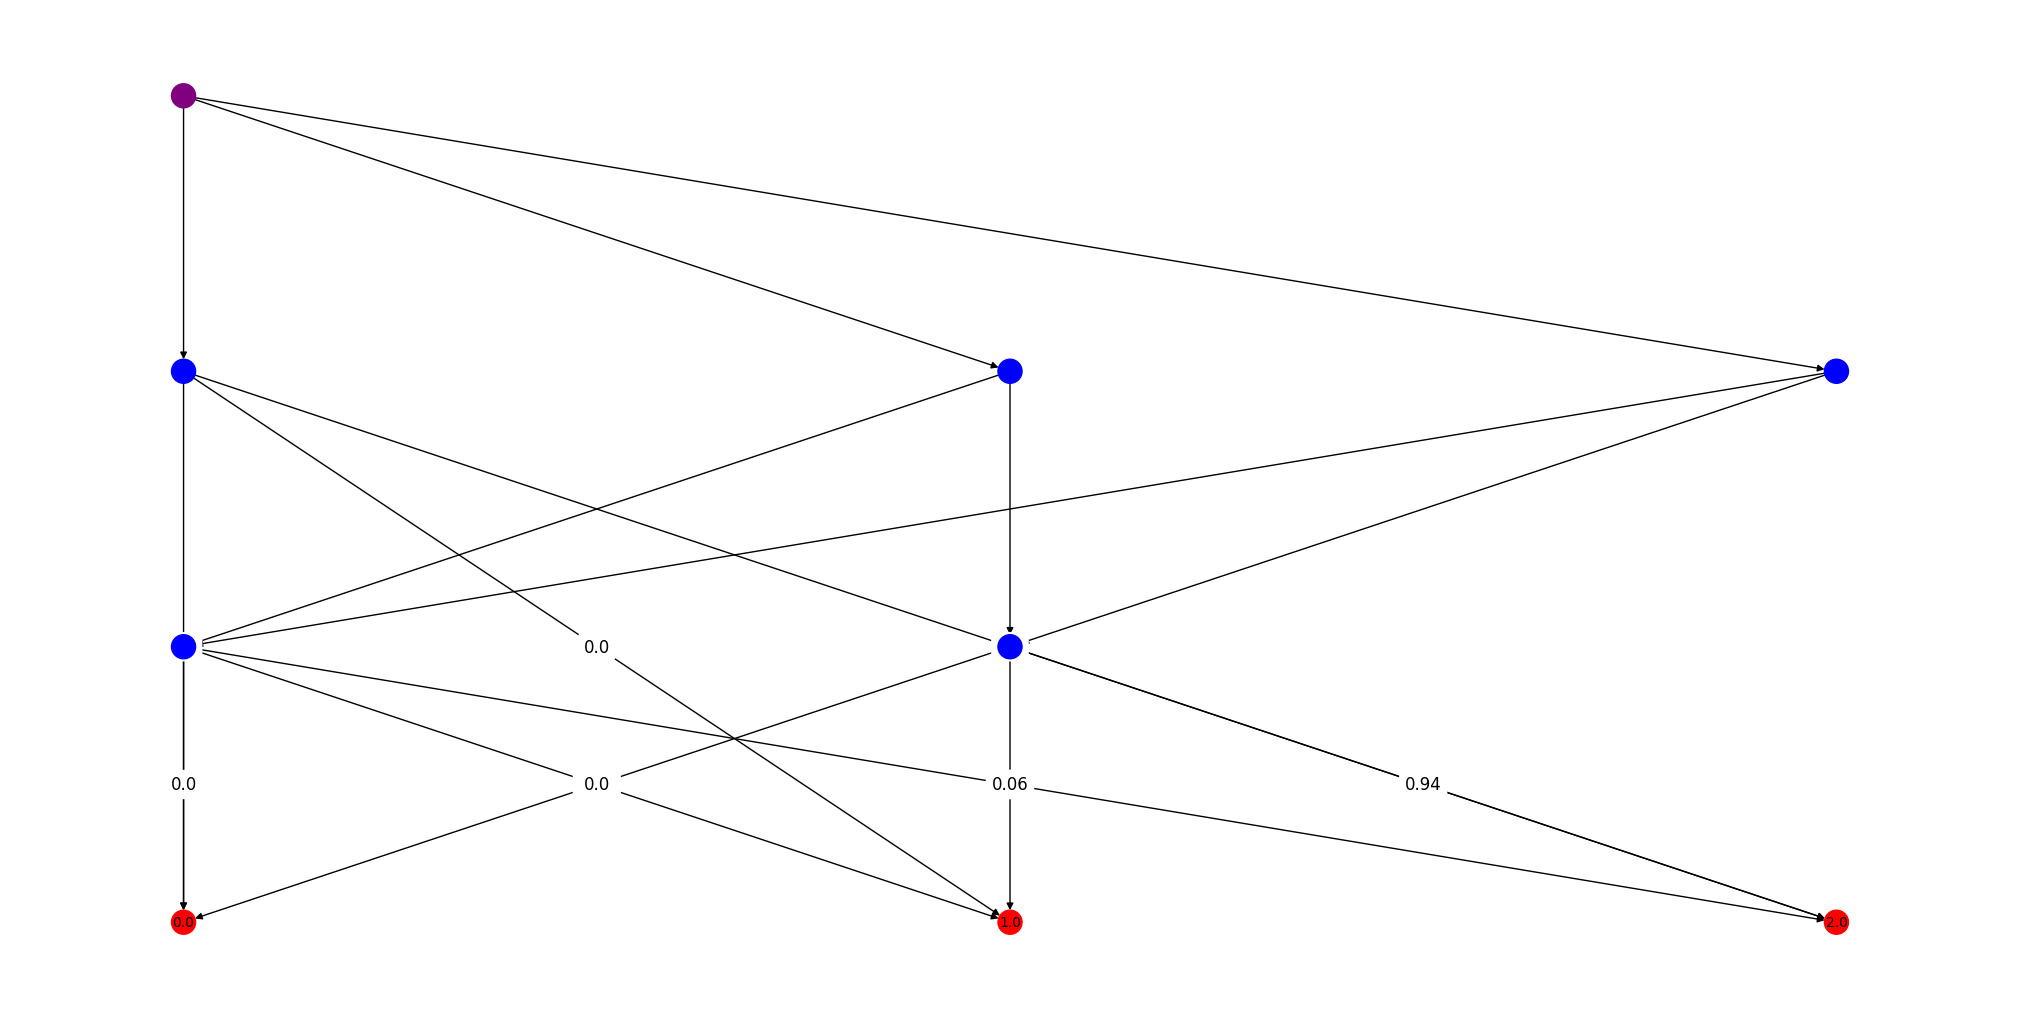

In [30]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

# Load the Iris dataset
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                    columns= iris['feature_names'] + ['target'])

# Convert numerical features to categorical by binning
for col in iris['feature_names']:
    data[col] = pd.cut(data[col], bins=3, labels=["low", "medium", "high"])

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and train the IFN model
target_var = 'target'
ifn_cat = IFN(train_data, target_var)
ifn_cat.fit()
ifn_cat.plot_network()

In [31]:
# Define the assistant function for classification report
def test_model(model, test_data):
    test_features = test_data.drop(columns=[target_var])
    test_labels = test_data[target_var].astype(int)

    predictions = model.predict(test_features)
    print(classification_report(test_labels, predictions))

# Calculate min error probability
print(f"Max error in the model based on Fano's Inequality: {ifn_cat.calculate_min_error_probability()}")

# Use the assistant function to get the classification report
test_model(ifn_cat, test_data)

Max error in the model based on Fano's Inequality: 0.03961727016264812
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Test on (ordinal) Iris

[Training Status]: Looking for optimal thresh points in numerical columns
Processing column: sepal length (cm)
Found significant split at 5.5 with significance 0.5588544570791389
Found significant split at 4.9 with significance 0.0296801786344838
Found significant split at 6.2 with significance 0.10057714480081742
Found significant split at 7.1 with significance 0.05255421377863724
Processing column: sepal width (cm)
Found significant split at 3.3 with significance 0.3103463455282002
Found significant split at 3.0 with significance 0.05514853002947063
Found significant split at 2.5 with significance 0.031246265382711455
Found significant split at 3.5 with significance 0.0322286767522592
Processing column: petal length (cm)
Found significant split at 3.0 with significance 0.9182958340544894
Found significant split at 4.8 with significance 0.4252746326897902
Found significant split at 5.2 with significance 0.06200683873943393
Processing column: petal width (cm)
Found significant split at

<ipython-input-46-9562bbb45d1c>:262: RuntimeWarning: divide by zero encountered in log2
  return {'weight': P_mutual * np.log2(P_Y_given_node/P_Y),
<ipython-input-46-9562bbb45d1c>:262: RuntimeWarning: invalid value encountered in scalar multiply
  return {'weight': P_mutual * np.log2(P_Y_given_node/P_Y),


[Train Status]: Current Level: petal length (cm), Best Split: petal width (cm)
[Train Status]: Current Level: petal width (cm), Best Split: sepal width (cm)
[Train Status]: Current Level: sepal width (cm), Best Split: sepal length (cm)
[Train Status]: Current Level: sepal length (cm), Best Split: None
[Train Status]: No attribute was chosen, define level nodes as terminal and exit function


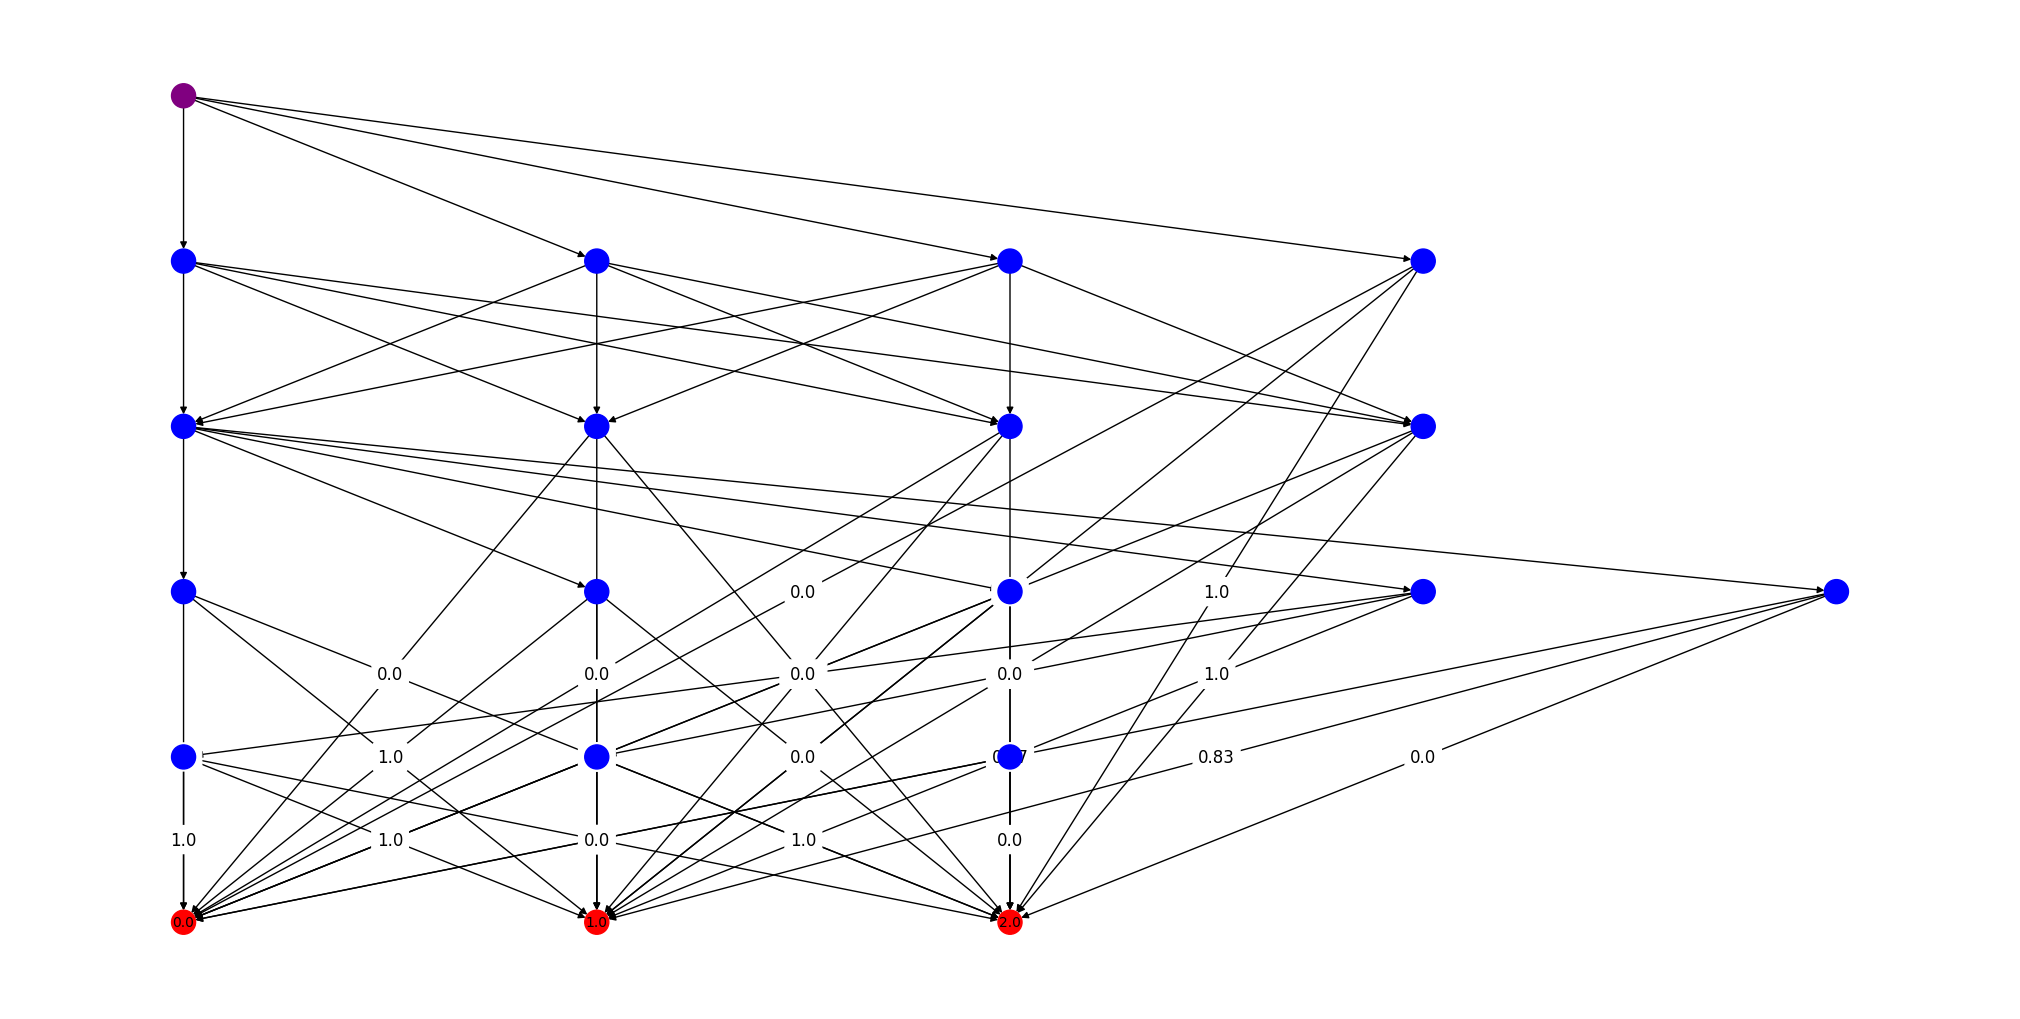

In [47]:
# Load the Iris dataset
iris = load_iris()
data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                    columns= iris['feature_names'] + ['target'])

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Initialize and train the IFN model
target_var = 'target'
ifn_ordinal = IFN(train_data, target_var)
ifn_ordinal.fit()
ifn_ordinal.plot_network()

In [49]:
# Define the assistant function for classification report
def test_model(model, test_data):
    test_features = test_data.drop(columns=[target_var])
    test_labels = test_data[target_var].astype(int)

    predictions = model.predict(test_features)
    print(classification_report(test_labels, predictions))

# Calculate min error probability
print(f"Max error in the model based on Fano's Inequality: {ifn_cat.calculate_min_error_probability()}")

# Use the assistant function to get the classification report
test_model(ifn_ordinal, test_data)

Max error in the model based on Fano's Inequality: 0.03961727016264812
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      1.00      0.95         9
           2       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

